In [165]:

import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [166]:
# Load and preprocess the dataset
df = pd.read_csv('SP500_with_indicators_^GSPC.csv').dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create lagged features
def create_lagged_features(data, lag=30):
    """
    Generate lagged features for time series prediction.
    """
    df_lagged = data.copy()
    for i in range(1, lag + 1):
        df_lagged[f'Lag_{i}'] = df_lagged['Adj Close'].shift(i)
    df_lagged.dropna(inplace=True)  # Drop rows with NaN values (due to lagging)
    return df_lagged

# Apply lagged features
lagged_df = create_lagged_features(df[['Adj Close']], lag=30)

# Prepare data for modeling
X = lagged_df.drop(columns=['Adj Close']).values
y = lagged_df['Adj Close'].values

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [167]:
# Time Series Cross-Validation 
tscv = TimeSeriesSplit(n_splits=5)

# Initialize Lasso Regression (L1 Regularization)
lasso_model = Lasso(alpha=0.1)

In [168]:
mae, rmse, r2 = [], [], []
fold = 1

for train_idx, test_idx in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Ridge Regression
    lasso_model.fit(X_train, y_train)
    lasso_pred = lasso_model.predict(X_test)
    mae.append(mean_absolute_error(y_test, lasso_pred))
    rmse.append(np.sqrt(mean_squared_error(y_test, lasso_pred)))
    r2.append(r2_score(y_test, lasso_pred))

    print(f'Fold {fold} - MAE: {mae[-1]:.2f}, RMSE: {rmse[-1]:.2f}, R2: {r2[-1]:.2f}')

print("\nCross-Validation Results (Average):")
print(f'MAE: {np.mean(mae):.2f}')
print(f'RMSE: {np.mean(rmse):.2f}')
print(f'R2: {np.mean(r2):.2f}')

Fold 1 - MAE: 8.34, RMSE: 11.19, R2: 0.99
Fold 1 - MAE: 12.56, RMSE: 17.79, R2: 0.99
Fold 1 - MAE: 12.45, RMSE: 16.00, R2: 1.00
Fold 1 - MAE: 15.93, RMSE: 21.86, R2: 1.00
Fold 1 - MAE: 34.35, RMSE: 48.20, R2: 0.99

Cross-Validation Results (Average):
MAE: 16.73
RMSE: 23.01
R2: 0.99


In [169]:
# Train-test split for final evaluation
split_idx = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

# Final evaluation
mae = mean_absolute_error(y_test, lasso_pred)
rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
r2 = r2_score(y_test, lasso_pred)

# 1% Error Check
lasso_accuracy = [abs((pred - actual) / actual) <= 0.01 for pred, actual in zip(lasso_pred, y_test)]
lasso_accuracy_rate = sum(lasso_accuracy) / len(lasso_accuracy) * 100

print("\nFinal Evaluation:")
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')
print(f'Accuracy within 1%: {lasso_accuracy_rate:.2f}%')




Final Evaluation:
MAE: 32.15
RMSE: 45.59
R2: 1.00
Accuracy within 1%: 67.93%


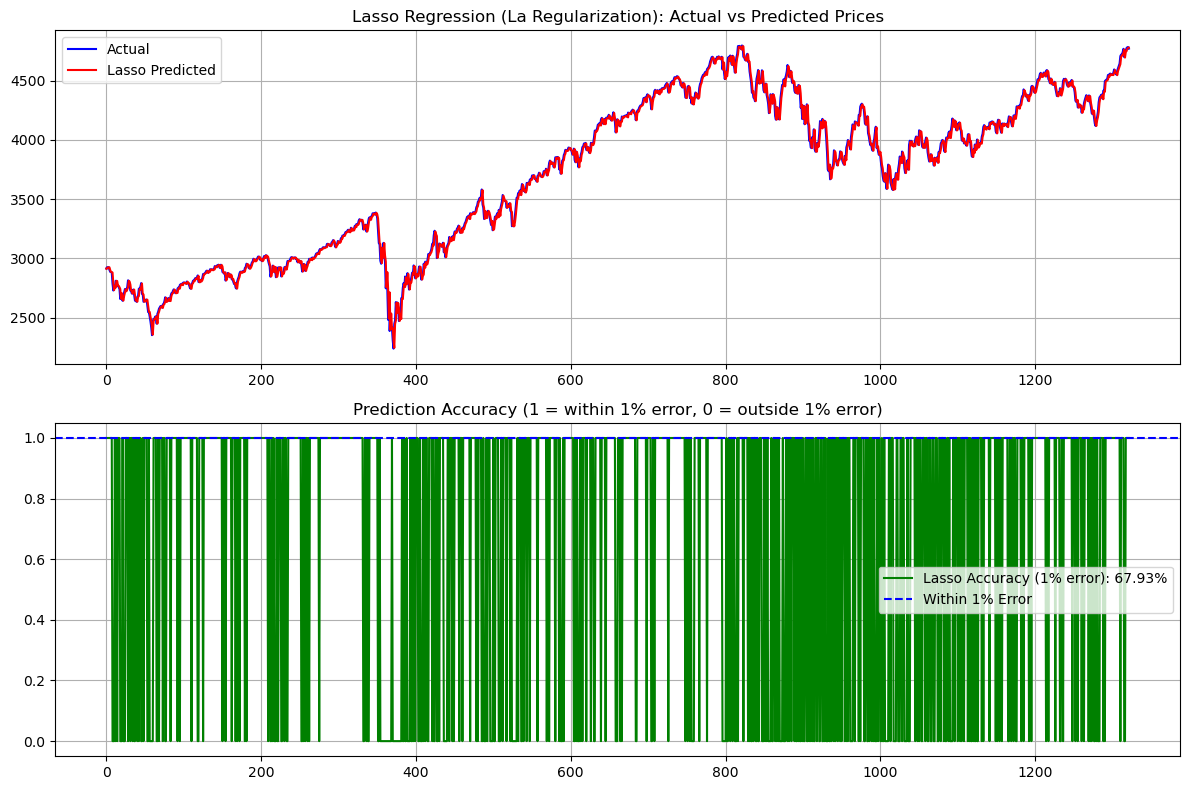

In [170]:
# Visualization
plt.figure(figsize=(12, 8))

# Lasso Regression: Actual vs Predicted
plt.subplot(2, 1, 1)
plt.plot(range(len(y_test)), y_test, label='Actual', color='blue')
plt.plot(range(len(lasso_pred)), lasso_pred, label='Lasso Predicted', color='red')
plt.title(f'Lasso Regression (La Regularization): Actual vs Predicted Prices')
plt.legend()
plt.grid(True)

# 1% Error Accuracy
plt.subplot(2, 1, 2)
lasso_accuracy_plot = [1 if abs((p - a) / a) <= 0.01 else 0 for p, a in zip(lasso_pred, y_test)]
plt.plot(lasso_accuracy_plot, label=f'Lasso Accuracy (1% error): {lasso_accuracy_rate:.2f}%', color='green')

plt.axhline(y=1, color='blue', linestyle='--', label='Within 1% Error')
plt.title('Prediction Accuracy (1 = within 1% error, 0 = outside 1% error)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
